# Predicciones de la calificación en un examen con _XGBoost_
La regresión se puede usar para cosas más mundanas y comunes, como la predicción de tu calificación en un examen. De haber sabido aprendizaje automático cuando cursaba la universidad, pude haber mejorado mis calificaciones o por lo menos saber por qué no salía tan bien como quería. Vamos a predecir calificaciones de estudiantes en un examen. Al final predeciré cuál habría sido mi calificación en esa prueba con base en lo que creo que hubieran sido mis características.

El conjunto de datos ha sido obtenido de [_Kaggle_ de nuevo.](https://www.kaggle.com/datasets/grandmaster07/student-exam-score-dataset-analysis/data) Hasta este punto ya van varios proyectos de regresión y clasificación donde hemos usado el flexible y robusto _XGBoost_. Éste será el último —por ahora—.

## Carga y exploración de datos
El _DataFrame_ tiene una calificación de usabilidad de 10 en _Kaggle_. Eso significa que no tiene datos nulos, duplicados ni incorrectos. Se trata de un _dataset_ limpio y numérico.

In [1]:
# Pandas, I love you.
import pandas as pd

# Cargamos el dataset descargado.
df = pd.read_csv('student_scores.csv')
print('Así luce la información:')
print(df.head(3))
print()
print('Tenemos seis columnas y no hay datos nulos.')
print(df.info())
print()
print('Éstos son algunos datos estadísticos.')
print(df.describe())

Así luce la información:
  student_id  hours_studied  sleep_hours  attendance_percent  previous_scores  \
0       S001            8.0          8.8                72.1               45   
1       S002            1.3          8.6                60.7               55   
2       S003            4.0          8.2                73.7               86   

   exam_score  
0        30.2  
1        25.0  
2        35.8  

Tenemos seis columnas y no hay datos nulos.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memor

El _dataset_ está tan ordenado que incluso las columnas siguen la convención _snake_case_. _Great!_

Un alumno que pertenezca al percentil 75 en todas las características estudia 9 horas por lo menos, duerme 8 horas por lo menos, va a un 87% de sus clases por lo menos y tuvo una calificación previa de por lo menos 80 sobre 100

## Limpieza y preprocesamiento
Vamos a separar las variables. En `X` contenemos las características y en `y` la variable objetivo. Vamos a deshacernos de  `student_id` en `X`, pues es un identificador y no aporta información relevante al modelo.

In [2]:
# 'X' almacena las características y 'y' almacena la variable objetivo.
X = df.drop(['student_id', 'exam_score'], axis=1)
y = df['exam_score']

## División y escalado
Ya lo sabes, _XGBoost_ no necesita de escalado, pero lo haremos para tenerlo presente.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Entrenamiento con _XGBoost_
El modelo tendrá 100 árboles de decisión débiles que se sumarán secuencialmente para corregir los errores que cometen los anteriores.

In [4]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

## Predicción y evaluación
Haremos uso de tres métricas de evaluación que ya hemos usado anteriormente con modelos de regresión: RMSE (raíz del error cuadrático), MAE (error absoluto medio) y R² (coeficiente de determinación).

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test_scaled)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")


RMSE: 3.28
MAE: 2.96
R²: 0.80


C:\Users\rober\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


El modelo predice bastante bien las calificaciones, con errores pequeños y un alto poder explicativo gracias a _XGBoost_. El modelo explica el 80% de la variabilidad total de las calificaciones de examen.

## Importancia de variables
¿Qué variable crees que es la más importante? ¿Las horas de estudio, el sueño?

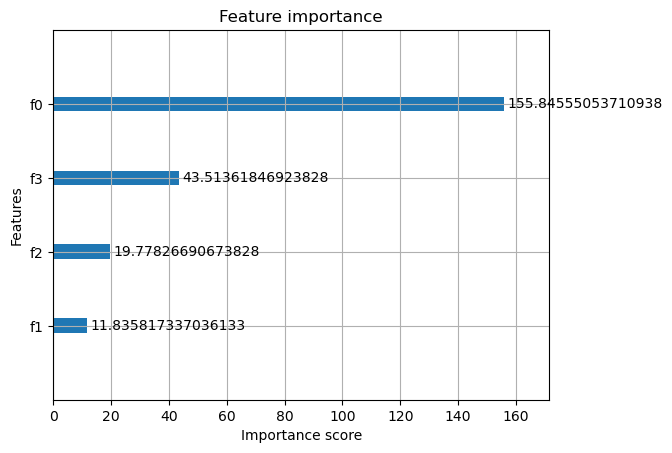

In [6]:
# Una gráfica simple que podemos desarrollar con matplotlib.
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='gain')
plt.show()


La variable más importante —por mucho— son las horas estudiadas, seguida de las calificaciones previas y el porcentaje de las clases a las que se asistió. No hay atajos en esto de salir bien en exámenes.

## Predicción personalizada
Ahora voy a hacer dos _DataFrames_ con las características. Un _dataset_ tendrá mis datos como estudiante antes la pandemia y el otro durante de la pandemia, pues mis hábitos eran considerablemente diferentes. Antes de la pandemia las clases eran presenciales y no descansaba tan bien; durante la pandemia mis clases fueron virtuales y eso me daba más tiempo para dormir y estudiar.

In [7]:
# Mis datos antes de la pandemia.
mis_datos_pre = pd.DataFrame({
    'hours_studied': [6], # Para mis exámenes generalmente estudiaba dos días, 3 horas por día.
    'sleep_hours': [6.5], # Había que levantarse temprano para ducharse.
    'attendance_percent': [80], # Tenía una asistencia decente.
    'previous_scores': [80] # Tenía buenas calificaciones, pero podía mejorar.
})

# Mis datos después de la pandemia.
mis_datos_post = pd.DataFrame({
    'hours_studied': [12], # Para mis exámenes generalmente estudiaba tres días, 4 horas por día.
    'sleep_hours': [8], # Mi semestre final fue desde casa debido a la pandemia y podía dormir bien.
    'attendance_percent': [95], # Era casi imposible faltar a clases desde casa.
    'previous_scores': [85] # En general siempre salía bien en los exámenes durante pandemia.
})

# Escalemos ambos datos.
mis_datos_pre_scaled = scaler.transform(mis_datos_pre)
mis_datos_post_scaled = scaler.transform(mis_datos_post)

mi_prediccion_pre = model.predict(mis_datos_pre_scaled)[0]
mi_prediccion_post = model.predict(mis_datos_post_scaled)[0]


print(f"Según mis hábitos pre-pandemia, mi calificación sería de {mi_prediccion_pre:.2f}")
print(f"Según mis hábitos post-pandemia, mi calificación sería de {mi_prediccion_post:.2f}")

Según mis hábitos pre-pandemia, mi calificación sería de 36.40
Según mis hábitos post-pandemia, mi calificación sería de 48.58


Como podemos ver, la diferencia en características como las horas de estudio y el sueño tienen una gran influencia en las calificaciones. Estudia mucho, pero también cuida tu cuerpo, así es como lograrás aprender más.

## Conclusión
Estudiar no es sólo parte de la vida del estudiante. Todo profesional debería mantenerse actualizado y en constante aprendizaje. Estudiar es necesario. Y si quieres mejorar tu rendimiento y aprendizaje deberías dormir bien.

Por ahora dejaremos descansar los modelos de _XGBoost_ y las predicciones. ¿Qué nos deparan los siguientes cuadernos? Nuevos conceptos fundamentales a través de proyectos sencillos y directos.